In [16]:
from helper_code import *
from team_code import *
from tqdm import tqdm
from datetime import time
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from helper_code import load_recording_data
import matplotlib as mpl

# Set global matplotlib config for bold axis labels
mpl.rcParams['axes.labelweight'] = 'bold'
# Configuración global para los gráficos de Matplotlib

plt.style.use('tableau-colorblind10')
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'axes.labelpad': 14,
    'xtick.labelsize': 16,  # Increased fontsize for x-ticks
    'xtick.major.pad': 5,
    'ytick.labelsize': 16,  # Increased fontsize for y-ticks
    'ytick.major.pad': 5,
    'legend.fontsize': 14,
    'figure.figsize': (10, 8)
})

# autoreload changes in helper_code and team_code
%load_ext autoreload
%autoreload 2


# Get the start time (as a time object) from the recording data.
def get_start_time_triplet(string):
    variable = get_variable(string, '#Start time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

# Get the end time (as a time object) from the recording data.
def get_end_time_triplet(string):
    variable = get_variable(string, '#End time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

DATA_FOLDER = "../data/"
ROOT_FOLDER = DATA_FOLDER + "physionet.org/files/i-care/2.1/training"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

def segmentos_5_minutos(start: time, end: time):
    # Convertir a datetime para facilitar los cálculos
    start_dt = datetime(2000, 1, 1, start.hour, start.minute, start.second)
    end_dt = datetime(2000, 1, 1, end.hour, end.minute, end.second)
    
    # Ajustar el inicio al siguiente múltiplo de 5 minutos
    start_min = (start_dt.minute // 5) * 5
    if start_dt.minute % 5 != 0 or start_dt.second > 0:
        start_min += 5
    
    # Controlar si start_min se vuelve 60 y ajustar la hora
    if start_min == 60:
        start_segment = datetime(2000, 1, 1, start_dt.hour + 1, 0, 0)
    else:
        start_segment = datetime(2000, 1, 1, start_dt.hour, start_min, 0)
    
    # Lista de segmentos
    segments = []
    
    while start_segment + timedelta(minutes=5) - timedelta(seconds=1) <= end_dt:
        end_minute = start_segment.minute + 4
        end_hour = start_segment.hour
        if end_minute >= 60:
            end_minute -= 60
            end_hour += 1
        
        segments.append((
            time(start_segment.hour, start_segment.minute, 0),
            time(end_hour, end_minute, 59)
        ))
        start_segment += timedelta(minutes=5)
    
    return segments

def dividir_dataframe_en_segmentos(df, start: time, end: time, sampling_frequency: int):
    samples_per_5_min = sampling_frequency * 5 * 60
    start_times = []
    end_times = []

    # If len is less that 5min do early return
    if len(df) < samples_per_5_min:
        return start_times, end_times

    segments = segmentos_5_minutos(start, end)
    

    for i, (start_frag, end_frag) in enumerate(segments):
        start_idx = i * samples_per_5_min
        end_idx = min(start_idx + samples_per_5_min, len(df))  # Asegurar que el índice no exceda el tamaño del DataFrame
        #df_list.append(df.iloc[start_idx:end_idx, :])  # Mantener indexación bidimensional
        start_times.append(start_frag)
        end_times.append(end_frag)
    
    return start_times, end_times

# Definir los tiempos de inicio y fin
start_time = time(23, 00, 0)
end_time = time(23, 59, 59)

# Crear un DataFrame de ejemplo con sampling_frequency de 128
sampling_frequency = 128  # 128 observaciones por segundo
total_seconds = (datetime(2000, 1, 1, end_time.hour, end_time.minute, end_time.second) - 
                 datetime(2000, 1, 1, start_time.hour, start_time.minute, start_time.second)).total_seconds()
data = {"col1": range(int(total_seconds * sampling_frequency)), "col2": range(int(total_seconds * sampling_frequency))}
df = pd.DataFrame(data)

# Obtener sub DataFrames
start_times, end_times = dividir_dataframe_en_segmentos(df, start_time, end_time, sampling_frequency)

# Imprimir cada sub DataFrame
for i, (start_frag, end_frag) in enumerate(zip(start_times, end_times)):
    print(f"Segmento {i + 1} (Inicio: {start_frag}, Fin: {end_frag}):")

Segmento 1 (Inicio: 23:00:00, Fin: 23:04:59):
Segmento 2 (Inicio: 23:05:00, Fin: 23:09:59):
Segmento 3 (Inicio: 23:10:00, Fin: 23:14:59):
Segmento 4 (Inicio: 23:15:00, Fin: 23:19:59):
Segmento 5 (Inicio: 23:20:00, Fin: 23:24:59):
Segmento 6 (Inicio: 23:25:00, Fin: 23:29:59):
Segmento 7 (Inicio: 23:30:00, Fin: 23:34:59):
Segmento 8 (Inicio: 23:35:00, Fin: 23:39:59):
Segmento 9 (Inicio: 23:40:00, Fin: 23:44:59):
Segmento 10 (Inicio: 23:45:00, Fin: 23:49:59):
Segmento 11 (Inicio: 23:50:00, Fin: 23:54:59):
Segmento 12 (Inicio: 23:55:00, Fin: 23:59:59):


In [3]:
# data12 = pd.read_csv(DATA_FOLDER + "official_scores_12.tsv", sep="\t", header=1)
# data24 = pd.read_csv(DATA_FOLDER + "official_scores_24.tsv", sep="\t", header=1)
# display(data12.head(5))
# display(data24.head(5))

In [4]:
data24 = pd.read_csv(DATA_FOLDER + "official_scores_24.tsv", sep="\t", header=1)
data24[["Rank", "Team", "Outcome AUROC on the test set",'Challenge Score on the test set' ]].iloc[0:30,:].to_csv("scores_24h.csv", index=False)
display(data24.head(10))

,Rank,Team,Challenge Score on the training set,Challenge Score on the validation set,Challenge Score on the test set,Outcome AUROC on the training set,Outcome AUROC on the validation set,Outcome AUROC on the test set,Outcome AUPRC on the training set,Outcome AUPRC on the validation set,...,Outcome Accuracy on the test set,Outcome F-measure on the training set,Outcome F-measure on the validation set,Outcome F-measure on the test set,CPC MSE on the training set,CPC MSE on the validation set,CPC MSE on the test set,CPC MAE on the training set,CPC MAE on the validation set,CPC MAE on the test set
0,1,AIrhythm,0.804,0.612,0.649,0.946,0.879,0.864,0.964,0.930,...,0.781,0.863,0.761,0.728,0.645,1.514,2.206,0.427,0.969,1.166
1,2,TUD_EEG,0.880,0.582,0.644,0.969,0.867,0.865,0.982,0.916,...,0.340,0.270,0.272,0.254,6.066,6.673,7.095,1.990,2.093,2.212
2,3,ComaToss,0.874,0.522,0.589,0.983,0.809,0.814,0.986,0.866,...,0.680,0.881,0.712,0.670,4.149,4.134,4.567,1.747,1.707,1.825
3,4,MIWEAR,0.492,0.493,0.554,0.844,0.846,0.801,0.897,0.905,...,0.693,0.507,0.462,0.493,2.583,2.518,2.742,1.236,1.246,1.286
4,5,PKU_NIHDS,0.853,0.567,0.525,0.962,0.879,0.808,0.975,0.915,...,0.673,0.852,0.751,0.664,0.892,2.035,2.471,0.570,0.954,1.130
5,6,The BEEGees,0.631,0.403,0.520,0.875,0.802,0.827,0.921,0.840,...,0.781,0.792,0.711,0.746,2.276,2.751,2.543,0.934,1.091,1.113
6,7,MetaHeart_YNNU,0.390,0.537,0.485,0.768,0.788,0.748,0.851,0.874,...,0.686,0.546,0.502,0.496,2.989,2.926,3.026,1.651,1.631,1.668
7,8,WesternUni,0.579,0.687,0.480,0.866,0.855,0.795,0.916,0.916,...,0.784,0.806,0.772,0.744,2.254,2.525,2.685,1.038,1.142,1.142
8,9,Blue and Gold,0.589,0.239,0.465,0.899,0.772,0.741,0.928,0.818,...,0.693,0.815,0.703,0.632,1.696,3.163,3.055,0.869,1.407,1.287
9,9,EEG pz lmn sqz,0.843,0.373,0.465,0.908,0.753,0.676,0.954,0.852,...,0.657,0.873,0.708,0.649,2.516,4.222,4.757,1.220,1.639,1.748


In [5]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.signal import resample

data_folder = ROOT_FOLDER
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)
current_features = None
GROUP = 'EEG'



def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def resample_segment(data, original_sampling_frequency, target_sampling_frequency):
    num_samples = int(data.shape[1] * target_sampling_frequency / original_sampling_frequency)
    resampled_data = resample(data, num_samples, axis=1)
    return resampled_data

In [6]:
N_HOURS = 12

MIN_MINUTES = 5
DROP_MEAN_STD = 0
DOUBLE_BANANA = [
        ("Fp1", "F7"), ("F7", "T3"), ("T3", "T5"), ("T5", "O1"),  # Left temporal chain
        ("Fp2", "F8"), ("F8", "T4"), ("T4", "T6"), ("T6", "O2"),  # Right temporal chain
        ("Fp1", "F3"), ("F3", "C3"), ("C3", "P3"), ("P3", "O1"),  # Left parasagittal chain
        ("Fp2", "F4"), ("F4", "C4"), ("C4", "P4"), ("P4", "O2"),  # Right parasagittal chain
        ("Fz", "Cz"), ("Cz", "Pz")                                # Central chain
]
BANDPASS_FREQS = [0.1, 45.0]
TARGET_SAMPLING_FREQUENCY = 128 # Nyquist

## Clinical features

In [7]:
data_folder = ROOT_FOLDER
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)
current_features = None

X_clinical = pd.DataFrame()

for i in tqdm(range(num_patients), desc="Processing patients", total=num_patients):
    current_features,_ = get_features(data_folder, patient_ids[i])
    # Extract labels.
    patient_metadata = load_challenge_data(data_folder, patient_ids[i])
    current_outcome = get_outcome(patient_metadata)

    current_cpc = get_cpc(patient_metadata)
    current_features.insert(0, "patient_id", patient_ids[i])
    current_features["outcome"] = current_outcome
    current_features["cpcs"] = current_cpc
    X_clinical = pd.concat([X_clinical, current_features], ignore_index=True)

X_clinical.to_csv(DATA_FOLDER+"X_clinical.csv", index=False)

display(X_clinical)

Processing patients: 100%|██████████| 607/607 [00:04<00:00, 127.74it/s]


,patient_id,hospital,age,sex,rosc,ohca,sr,ttm,outcome,cpcs
0,0284,A,53.0,Male,NaN,1.0,1.0,33.0,0,1.0
1,0286,F,85.0,Female,7.0,0.0,0.0,NaN,0,1.0
2,0296,A,48.0,Male,NaN,1.0,1.0,36.0,0,1.0
3,0299,A,45.0,Male,NaN,1.0,1.0,33.0,0,1.0
4,0303,D,51.0,Male,24.0,1.0,1.0,33.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
602,1016,E,87.0,Male,7.0,1.0,0.0,33.0,1,5.0
603,1017,F,26.0,Male,52.0,1.0,0.0,NaN,1,5.0
604,1018,E,63.0,Male,NaN,1.0,1.0,36.0,1,5.0
605,1019,A,72.0,Male,NaN,1.0,1.0,36.0,0,1.0


In [8]:
import pandas as pd
import numpy as np

# Copy the original DataFrame to work on
df = X_clinical.copy()

# Total patient count per hospital
counts = df.groupby("hospital").size().to_frame(name="N")

# Create TTM binary columns
# df["TTM 33"] = (df["ttm"] == 33.0).astype(int)
# df["TTM 36"] = (df["ttm"] == 36.0).astype(int)
# df["No TTM"] = df["ttm"].isna().astype(int)

df["Female"] = (df["sex"] == "Female").astype(int)

# List of numeric variables (excluding patient_id and TTM)
numeric_vars = ["age", "rosc", "ttm"]

# Compute mean ± std for numeric vars
numeric_stats = {}
for var in numeric_vars:
    stat = df.groupby("hospital")[var].agg(["mean", "std"])
    stat_formatted = stat.apply(
        lambda row: f"{row['mean']:.1f} ± {row['std']:.1f}", axis=1
    )
    numeric_stats[var] = stat_formatted

# List of binary variables
binary_vars = ["Female", "ohca", "sr"]

# Compute count and percentage for binary vars
binary_stats = {}
for var in binary_vars:
    stat = df.groupby("hospital")[var].agg(["sum", "count"])
    stat["percent"] = (stat["sum"] / stat["count"]) * 100
    stat_formatted = stat.apply(
        lambda row: f"{int(row['sum'])} ({row['percent']:.1f}%)", axis=1
    )
    binary_stats[var] = stat_formatted

binary_df = pd.DataFrame(binary_stats)

numeric_df = pd.DataFrame(numeric_stats)

# Combine all tables
final_table = pd.concat([counts, numeric_df, binary_df], axis=1).transpose()

# Show table
print(final_table)

hospital            A            B            D            E            F
N                 261          120           83           74           69
age       63.0 ± 12.8  60.3 ± 17.6  57.0 ± 18.1  63.8 ± 15.0  57.9 ± 17.9
rosc        nan ± nan  23.6 ± 19.4  31.0 ± 24.9  17.7 ± 12.9  21.0 ± 11.7
ttm        33.6 ± 1.2   33.0 ± 0.0   33.1 ± 0.6   33.4 ± 1.1   33.0 ± 0.0
Female     74 (28.4%)   34 (28.3%)   25 (30.1%)   27 (36.5%)   27 (39.1%)
ohca      211 (89.8%)   66 (55.0%)   57 (79.2%)   61 (85.9%)   47 (69.1%)
sr        168 (73.4%)   51 (42.5%)   32 (38.6%)   23 (31.1%)   23 (33.3%)


In [9]:
X_clinical["cpcs"].value_counts(normalize=True)*100

cpcs
5.0    58.154860
1.0    29.818781
2.0     7.248764
3.0     3.294893
4.0     1.482702
Name: proportion, dtype: float64

## Descriptive


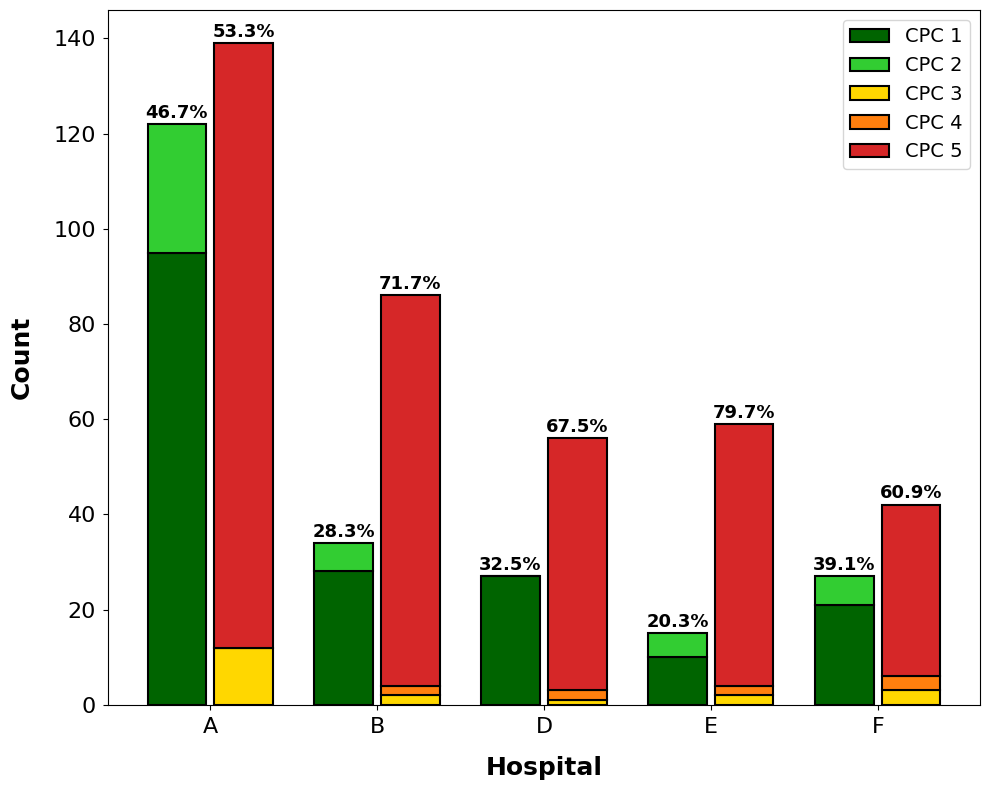

In [11]:



# Colores personalizados para los CPCs
colors = {
    1.0: '#006400',  # Verde oscuro
    2.0: '#32CD32',  # Verde claro
    3.0: '#FFD700',  # Amarillo
    4.0: '#ff7f0e',  # Naranja
    5.0: '#d62728'   # Rojo
}

# Filtrar los datos por CPCs
cpc_1_2 = X_clinical[X_clinical['cpcs'].isin([1.0, 2.0])]
cpc_3_4_5 = X_clinical[X_clinical['cpcs'].isin([3.0, 4.0, 5.0])]

# Agrupar por hospital y contar los valores de CPCs
cpc_1_2_counts = cpc_1_2.groupby('hospital')['cpcs'].value_counts().unstack(fill_value=0)
cpc_3_4_5_counts = cpc_3_4_5.groupby('hospital')['cpcs'].value_counts().unstack(fill_value=0)

# Crear el gráfico
fig, ax = plt.subplots()

# Obtener los índices de los hospitales
hospitals = cpc_1_2_counts.index
x = np.arange(len(hospitals))  # Posiciones de los hospitales en el eje x
width = 0.35  # Ancho de las barras
separation = 0.05  # Separación entre pares de barras

# Barras CPC 1 y 2 (apiladas)
for cpc in [1.0, 2.0]:
    if cpc > 1.0:
        bottom = cpc_1_2_counts.loc[:, :cpc-1].sum(axis=1)
    else:
        bottom = pd.Series(0, index=hospitals)
    
    ax.bar(x - width/2 - separation/2, cpc_1_2_counts[cpc], width, 
           label=f'CPC {int(cpc)}', bottom=bottom, color=colors[cpc], edgecolor='black', linewidth=1.5)

# Barras CPC 3, 4 y 5 (apiladas)
for cpc in [3.0, 4.0, 5.0]:
    if cpc > 3.0:
        bottom = cpc_3_4_5_counts.loc[:, :cpc-1].sum(axis=1)
    else:
        bottom = pd.Series(0, index=hospitals)

    ax.bar(x + width/2 + separation/2, cpc_3_4_5_counts[cpc], width, 
           label=f'CPC {int(cpc)}', bottom=bottom, color=colors[cpc], edgecolor='black', linewidth=1.5)

# Calcular totales por hospital
total_counts = (cpc_1_2_counts.sum(axis=1) + cpc_3_4_5_counts.sum(axis=1))

# Suma total de cada barra (apilada) por hospital
cpc_1_2_total = cpc_1_2_counts.sum(axis=1)
cpc_3_4_5_total = cpc_3_4_5_counts.sum(axis=1)

# Porcentajes de cada barra respecto al total del hospital
cpc_1_2_pct = (cpc_1_2_total / total_counts) * 100
cpc_3_4_5_pct = (cpc_3_4_5_total / total_counts) * 100

# Colocar porcentaje en el top de cada barra completa
for i, hosp in enumerate(hospitals):
    ax.text(x[i] - width/2 - separation/2, cpc_1_2_total[hosp] + 0.5, f'{cpc_1_2_pct[hosp]:.1f}%', 
            ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    ax.text(x[i] + width/2 + separation/2, cpc_3_4_5_total[hosp] + 0.5, f'{cpc_3_4_5_pct[hosp]:.1f}%', 
            ha='center', va='bottom', fontsize=13, fontweight='bold')

# Configuración final
ax.set_xlabel('Hospital', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(hospitals)
ax.legend(fontsize=14)
plt.tight_layout()
plt.savefig("../img/hosp_count.png", dpi=300, bbox_inches="tight")
plt.show()

Creating RawArray with float64 data, n_channels=19, n_times=30000
    Range : 0 ... 29999 =      0.000 ...    59.998 secs
Ready.


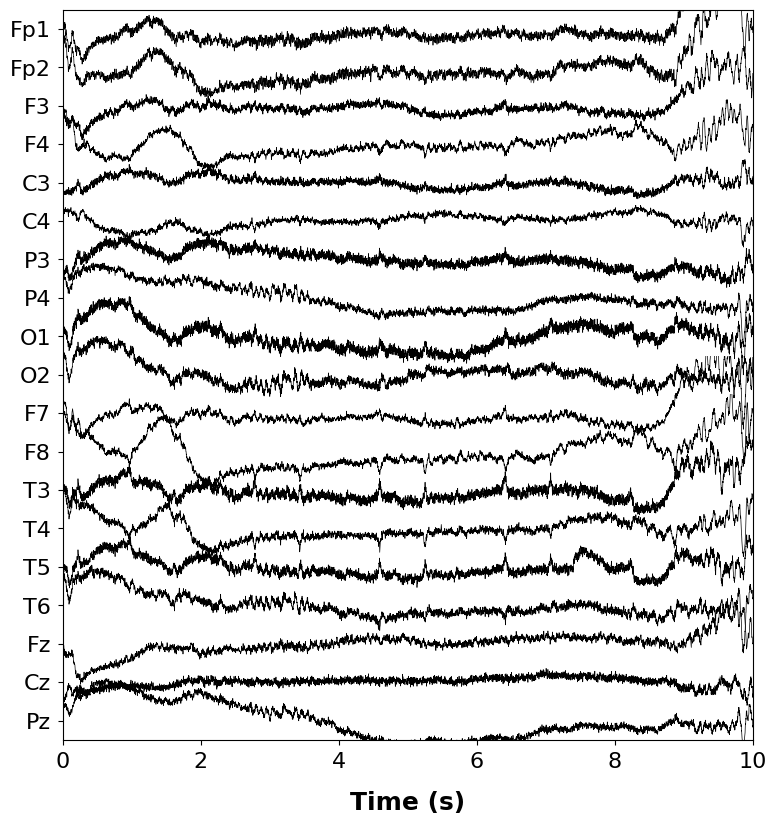

Creating RawArray with float64 data, n_channels=18, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


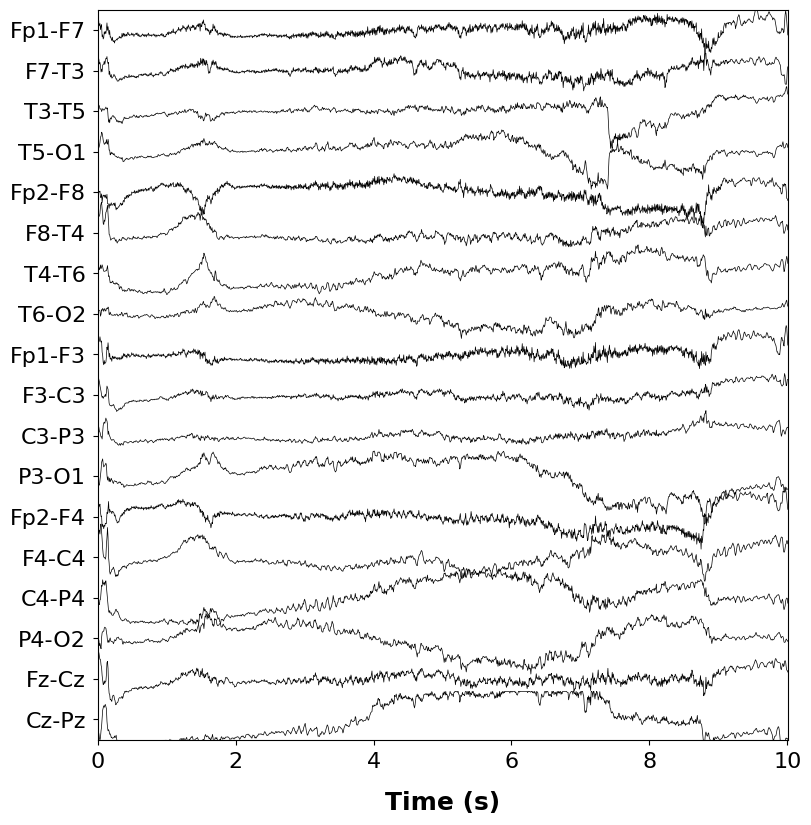

In [15]:
import mne
import numpy as np

# Load recording
recording_path = "../data/physionet.org/files/i-care/2.1/training/0284/0284_010_012_EEG"
data, channels, sfreq = load_recording_data(recording_path)
utility_freq = get_utility_frequency(recording_path + ".hea")

# Plot and save raw EEG data (first 60 seconds)
n_samples = int(sfreq * 60)
info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(data[:, :n_samples], info)
fig = raw.plot(
    scalings="auto",
    title="Raw EEG Data",
    show=True,
    block=False,
    remove_dc=True,
    show_scrollbars=False,
    show_scalebars=False,
)

fig.savefig("../img/eeg_raw.png", dpi=300, bbox_inches="tight", pad_inches=0.2)

# Preprocess data
data_preproc, sfreq = preprocess_data(data, sfreq, utility_freq, channels)
data_preproc = get_bipolar_data(data_preproc)  # Apply double-banana montage
channels = list(data_preproc.columns)

# Plot and save preprocessed EEG data
data_preproc = data_preproc.to_numpy().T
n_samples = int(sfreq * 60)
info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(data_preproc[:, :n_samples], info)
fig = raw.plot(
    scalings=1,
    title="Preprocessed EEG Data",
    show=True,
    block=False,
    remove_dc=True,
    show_scrollbars=False,
    show_scalebars=False,
)
fig.savefig("../img/eeg_preprocessed.png", dpi=300, bbox_inches="tight", pad_inches=0.2)


In [ ]:
def compute_challenge_score(labels, outputs, hospitals):
    # Check the data.
    assert len(labels) == len(outputs)

    # Convert the data to NumPy arrays for easier indexing.
    labels = np.asarray(labels, dtype=np.float64)
    outputs = np.asarray(outputs, dtype=np.float64)

    # Identify the unique hospitals.
    unique_hospitals = sorted(set(hospitals))
    num_hospitals = len(unique_hospitals)

    # Initialize a confusion matrix for each hospital.
    tps = np.zeros(num_hospitals)
    fps = np.zeros(num_hospitals)
    fns = np.zeros(num_hospitals)
    tns = np.zeros(num_hospitals)

    # Compute the confusion matrix at each output threshold separately for each hospital.
    for i, hospital in enumerate(unique_hospitals):
        idx = [j for j, x in enumerate(hospitals) if x == hospital]
        current_labels = labels[idx]
        current_outputs = outputs[idx]
        num_instances = len(current_labels)

        # Collect the unique output values as the thresholds for the positive and negative classes.
        thresholds = np.unique(current_outputs)
        thresholds = np.append(thresholds, thresholds[-1]+1)
        thresholds = thresholds[::-1]
        num_thresholds = len(thresholds)

        idx = np.argsort(current_outputs)[::-1]

        # Initialize the TPs, FPs, FNs, and TNs with no positive outputs.
        tp = np.zeros(num_thresholds)
        fp = np.zeros(num_thresholds)
        fn = np.zeros(num_thresholds)
        tn = np.zeros(num_thresholds)

        tp[0] = 0
        fp[0] = 0
        fn[0] = np.sum(current_labels == 1)
        tn[0] = np.sum(current_labels == 0)

        # Update the TPs, FPs, FNs, and TNs using the values at the previous threshold.
        k = 0
        for l in range(1, num_thresholds):
            tp[l] = tp[l-1]
            fp[l] = fp[l-1]
            fn[l] = fn[l-1]
            tn[l] = tn[l-1]

            while k < num_instances and current_outputs[idx[k]] >= thresholds[l]:
                if current_labels[idx[k]] == 1:
                    tp[l] += 1
                    fn[l] -= 1
                else:
                    fp[l] += 1
                    tn[l] -= 1
                k += 1

            # Compute the FPRs.
            fpr = np.zeros(num_thresholds)
            for l in range(num_thresholds):
                if tp[l] + fn[l] > 0:
                    fpr[l] = float(fp[l]) / float(tp[l] + fn[l])
                else:
                    fpr[l] = float('nan')

            # Find the threshold such that FPR <= 0.05.
            max_fpr = 0.05
            if np.any(fpr <= max_fpr):
                l = max(l for l, x in enumerate(fpr) if x <= max_fpr)
                tps[i] = tp[l]
                fps[i] = fp[l]
                fns[i] = fn[l]
                tns[i] = tn[l]
            else:
                tps[i] = tp[0]
                fps[i] = fp[0]
                fns[i] = fn[0]
                tns[i] = tn[0]

    # Compute the TPR at FPR <= 0.05 for each hospital.
    tp = np.sum(tps)
    fp = np.sum(fps)
    fn = np.sum(fns)
    tn = np.sum(tns)

    if tp + fn > 0:
        max_tpr = tp / (tp + fn)
    else:
        max_tpr = float('nan')

    return max_tpr

In [29]:
!python --version

Python 3.10.10


In [28]:
# generate random labels
labels = np.random.randint(0, 2, size=1000)
# generate random outputs
outputs = np.random.rand(1000)
# compute the score
score = compute_challenge_score(labels, outputs)
print(f"Score: {score:.4f}")


Score: 0.0470


## FMM features

In [ ]:
X_fmm = pd.DataFrame(columns=["id_patient", "id_hour", "id_window", "id_epoch", "id_wave"])
X_fmm = pd.DataFrame()

segment_df = pd.DataFrame(columns=["id_patient", "id_hour", "start_time", "end_time"])

for i in tqdm(range(num_patients), desc="Processing patients", total=num_patients):
    patient_id = patient_ids[i]
    patient_metadata = load_challenge_data(data_folder, patient_id)
    recording_ids = find_recording_files(data_folder, patient_id)
    num_recordings = len(recording_ids)
    # print(patient_metadata)
    # print(recording_ids)
    for recording_id in recording_ids:
        recording_location = os.path.join(data_folder, patient_id, '{}_{}'.format(recording_id, GROUP))
        
        #recording_location = "../data/physionet.org/files/i-care/2.1/training/0284/0284_010_012_EEG"
        with open(recording_location + '.hea', 'r') as f:
            header = f.read()
            start_time = get_start_time_triplet(header)
            end_time = get_end_time_triplet(header)

        data, channels, sampling_frequency = load_recording_data(recording_location)
        data = pd.DataFrame(data.T)

        frag_start_times, frag_end_times = dividir_dataframe_en_segmentos(data, start_time, end_time, sampling_frequency)

        segment_df = pd.concat([segment_df, pd.DataFrame({
            "id_patient": [patient_id] * len(frag_start_times),
            "id_hour": [recording_id.split('_')[-1]] * len(frag_start_times),
            "start_time": frag_start_times,
            "end_time": frag_end_times
        })])
        continue

        utility_frequency = get_utility_frequency(recording_location + '.hea')
        data, sampling_frequency = preprocess_data(data, sampling_frequency, utility_frequency)
        data = get_bipolar_data(data, channels, sampling_frequency) # Create double-banana montage
        if data is None:
            continue
        raise ValueError
    # Filtrar los segmentos correspondientes a la hora deseada (por ejemplo, hora 8)
    # crea uina lista con todas las horas desde la 0 hasta la 23 con formato 000, 001, 002, ..., 023
    # HOURS = [str(hour).zfill(3) for hour in range(N_HOURS)]
    # for hour in HOURS:
    #     hour = '008'
    #     hour_segments = [rec_id for rec_id in recording_ids if rec_id.split('_')[-1] == hour]

    #     if not hour_segments:
    #         continue

    #     segments = []
    #     start_times = []
    #     end_times = []
    #     for recording_id in hour_segments:
    #         recording_location = os.path.join(data_folder, patient_id, '{}_{}'.format(recording_id, GROUP))
    #         with open(recording_location + '.hea', 'r') as f:
    #             header = f.read()
    #             start_time = get_start_time_triplet(header)
    #             end_time = get_end_time_triplet(header)
    #             start_times.append(start_time)
    #             end_times.append(end_time)
    #         data, channels, original_sampling_frequency = load_recording_data(recording_location)
 
    #         resampled_data = resample_segment(data, original_sampling_frequency, TARGET_SAMPLING_FREQUENCY)
    #         print(resampled_data.shape)
    #         segments.append(resampled_data)
segment_df = segment_df.reset_index(drop=True)
segment_df.to_csv("../data/segment_df.csv", index=False)

Processing patients: 100%|██████████| 607/607 [1:34:01<00:00,  9.29s/it]


: 

## EEG spectral bands

In [18]:
recording_path = "../data/physionet.org/files/i-care/2.1/training/0674/0674_002_014_EEG"
signal, channels, fs = load_recording_data(recording_path)
# resample signal to 128 Hz
data = signal[0, 0:int(10 * fs)]

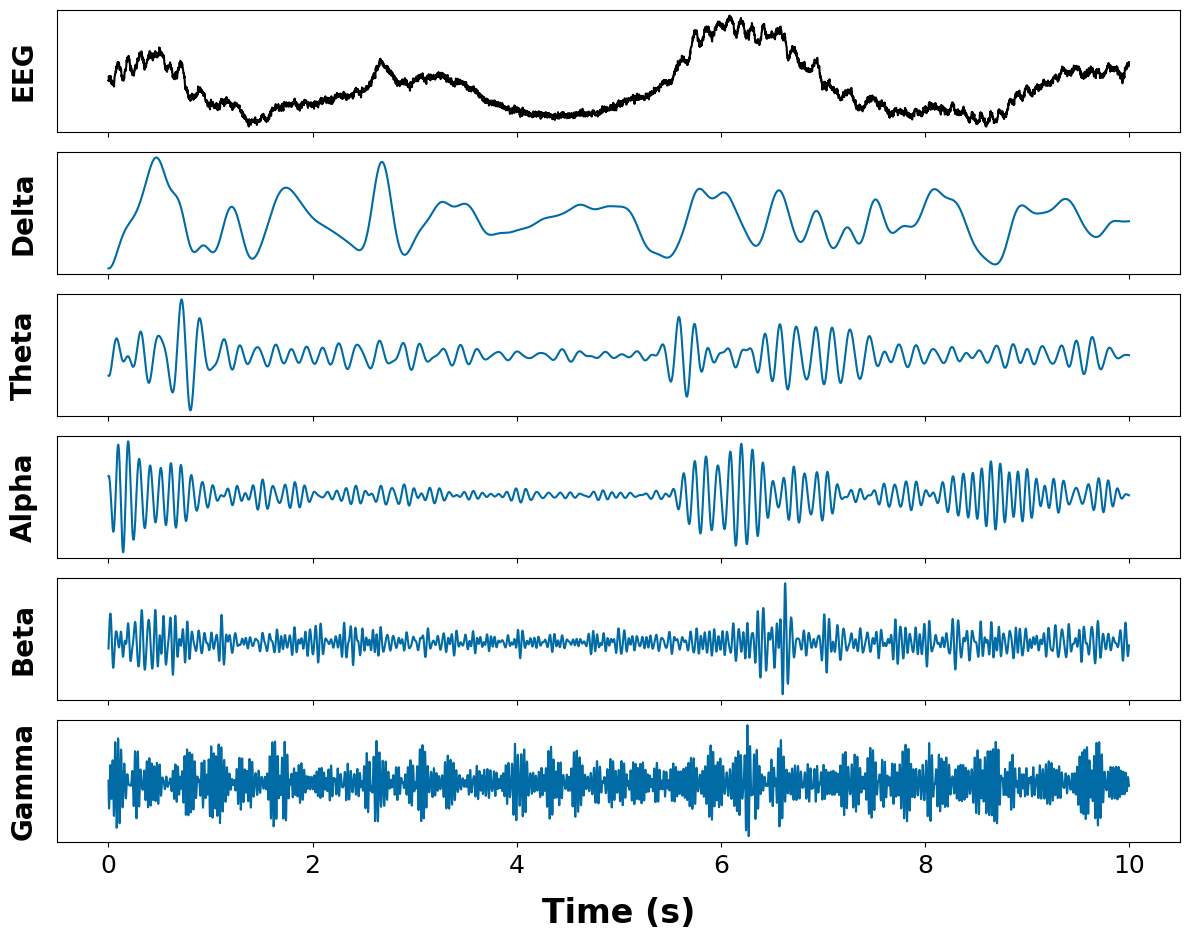

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ====================
# CONSTANTES DE CONFIGURACIÓN
# ====================

FIGSIZE = (12, 10)
LABELSIZE = 20
TICKSIZE = 18
TITLESIZE = 16
LINEWIDTH = 1.5

# ====================
# DATA
# ====================

t = np.linspace(0, len(data)/fs, len(data))
df = pd.DataFrame({'time': t, 'signal': data})

# ====================
# FUNCIONES
# ====================

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# ====================
# BANDAS DE FRECUENCIA
# ====================

bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 45)
}

# ====================
# PLOTEO
# ====================

fig, axs = plt.subplots(len(bands)+1, 1, figsize=FIGSIZE, sharex=True)

# Señal original
axs[0].plot(df['time'], df['signal'], color='black', linewidth=LINEWIDTH)
axs[0].set_ylabel('EEG', fontsize=LABELSIZE)
axs[0].set_yticks([])
axs[0].tick_params(axis='both', which='major', labelsize=TICKSIZE)

# Bandas filtradas
for i, (band_name, (low, high)) in enumerate(bands.items(), start=1):
    filtered_signal = bandpass_filter(df['signal'], low, high, fs)
    axs[i].plot(df['time'], filtered_signal, linewidth=LINEWIDTH)
    axs[i].set_ylabel(band_name, fontsize=LABELSIZE)
    axs[i].set_yticks([])
    axs[i].tick_params(axis='both', which='major', labelsize=TICKSIZE)

# Etiqueta de eje X y título general
axs[-1].set_xlabel('Time (s)', fontsize=24)

# Ajuste de layout y guardado
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../img/spectral_bands.png", dpi=300, bbox_inches="tight")
plt.show()
